## easyEphys

Notebook designed for basic ephys visualization and analysis. Uses ```braingeneerspy``` and ```spike data```.

Use appropriate block for either pulling from S3 or local file system.

*Currently local file loading does not allow for positions to be plotted*

### Include required libraries

In [16]:
from braingeneers import analysis
from braingeneers.analysis import load_spike_data
from braingeneers.data import datasets_electrophysiology as ephys
import zipfile
import matplotlib.pyplot as plt
import numpy as np

### Use this block if loading from S3 ###
change the ```uuid``` and ```experiment_id``` to the one you want to load


In [17]:
# Change the uuid and exp to the data you want to load
uuid = '2024-11-12-e-SmitsMidbrain-DIV6'   
experiment_id = '24432_SmitsMO_D60_sect300_T2PostDrug150-DIV6_20241112_phy'      #only include the base name with _phy

In [18]:
# Loads, may take a while
metadata = ephys.load_metadata(uuid)
spike_data = load_spike_data(uuid, experiment_id, groups_to_load= ['good'])

In [19]:
# Time is separate for each due to conflicting time scales
_,times = spike_data.idces_times()
times = np.array(times) / 60 / 1000

### Use this block if loading from local file (WIP - Spatial Plots not working yet)

change ```experiment_path``` to the path of the file you want to load

In [1]:
def load_curation(qm_path):
    with zipfile.ZipFile(qm_path, 'r') as f_zip:
        qm = f_zip.open("qm.npz")
        data = np.load(qm, allow_pickle=True)
        spike_times = data["train"].item()
        fs = data["fs"]
        train = [times / fs for _, times in spike_times.items()]

        if "config" in data:
            config = data["config"].item()
        else:
            config = None
        neuron_data = data["neuron_data"].item()
        
        return analysis.SpikeData(train, neuron_data={0: neuron_data})
    
    return spike_data

In [ ]:
exp_path = '/Users/noah/Desktop/test.zip'       # Change to the path of the zip file for local load
spike_data = load_curation(exp_path)

# time
_,times = spike_data.idces_times()
times = np.array(times) / 60

______

### Raster Plot

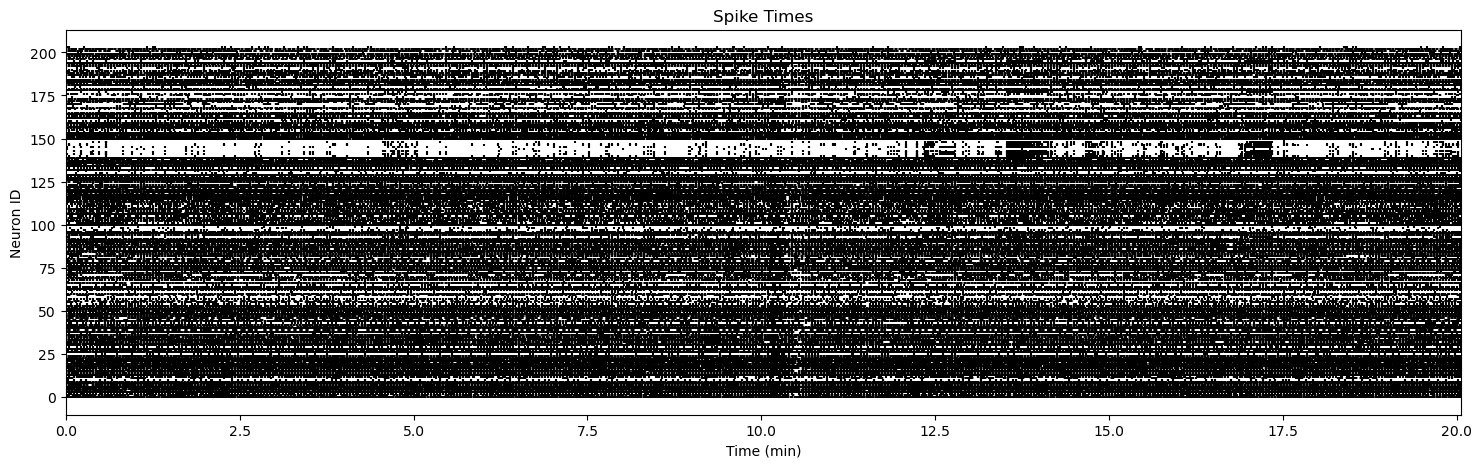

In [45]:
# data for raster
t_min = 0
t_max = max(times)  # Change if you want consistent x-axis

# spike times
idces,_ = spike_data.idces_times()

# Plotting
fig, ax = plt.subplots(figsize=(18, 5))
ax.set_xlim(0, t_max)
plt.scatter(times, idces, s=1, c= 'black', marker= '|', alpha=1)
plt.xlabel('Time (min)')
plt.ylabel('Neuron ID')
plt.title('Spike Times')
plt.show()

### Pop Firing Rate

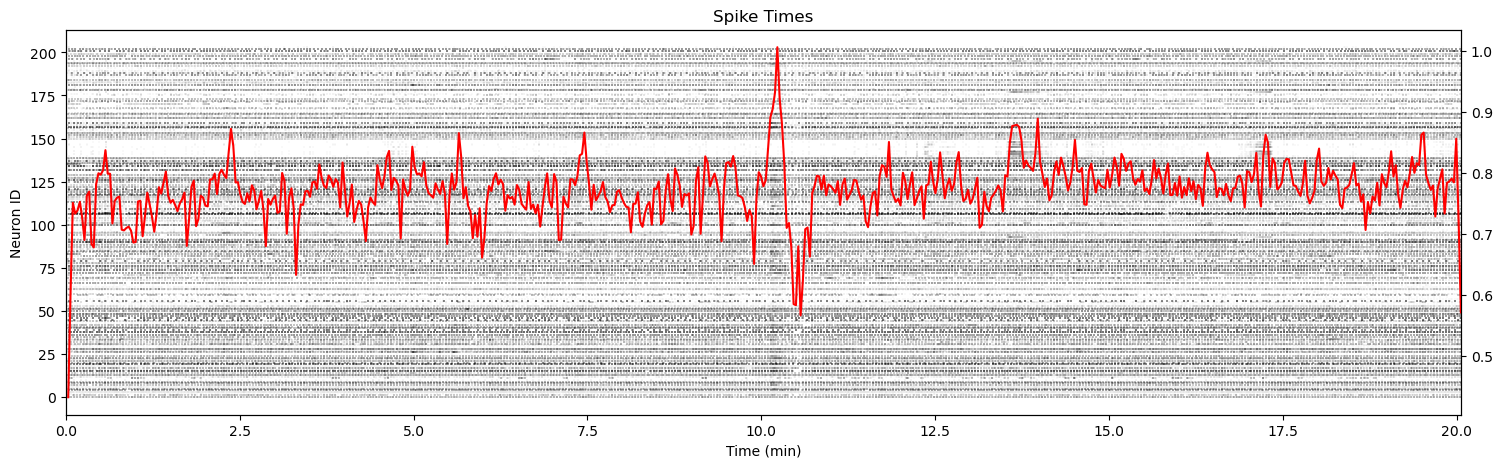

In [46]:
# Raster
fig, ax = plt.subplots(1,1, figsize = (18,5))
ax.scatter(times, idces, s = 1, marker= '|', c= 'k', alpha= .025)
ax.set_xlabel('Time (min)')
ax.set_ylabel('Neuron ID')
ax.set_title('Spike Times')
ax.set_xlim(t_min, t_max)

# Binned pop firing rate
bins, pop_rate = spike_data.population_firing_rate(bin_size=t_max*100)
ax2 = ax.twinx()``
ax2.plot(bins[1:]/60/1000, pop_rate,'r')
plt.show()

### Spatial Map

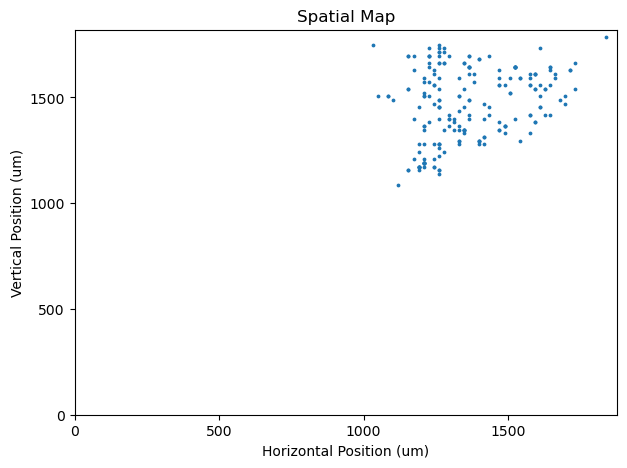

In [49]:
# Create arrays for x and y positions
x = []
y = []
for neuron in range(len(spike_data.neuron_attributes)):
    x.append(spike_data.neuron_attributes[neuron].position[0])
    y.append(spike_data.neuron_attributes[neuron].position[1])

# Plotting
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(x, y, s=3)
plt.xticks(np.arange(0, max(x), 500))
plt.yticks(np.arange(0, max(y), 500))
plt.xlabel('Horizontal Position (um)')
plt.ylabel('Vertical Position (um)')
plt.title('Spatial Map')
plt.show()


### Spatial Map with Average Firing Rates

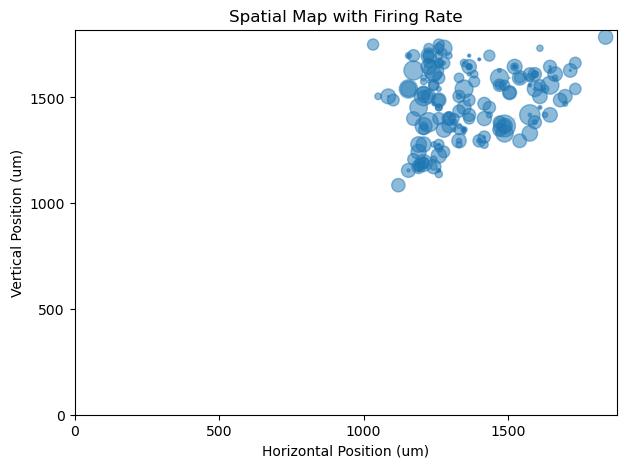

In [59]:
# Calc avg firing rate for each neuron
avg_firing_rate = []
for neuron in spike_data.train:
    firing_rate = len(neuron) / t_max
    avg_firing_rate.append(firing_rate)
npdarray = np.array(avg_firing_rate)            # you been numpy'd!

# Plotting
x = []
y = []
for neuron in range(len(spike_data.neuron_attributes)):
    x.append(spike_data.neuron_attributes[neuron].position[0])
    y.append(spike_data.neuron_attributes[neuron].position[1])
fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(x, y, s= npdarray * .25, alpha=.5)
plt.xticks(np.arange(0, max(x), 500))
plt.yticks(np.arange(0, max(y), 500))
plt.xlabel('Horizontal Position (um)')
plt.ylabel('Vertical Position (um)')
plt.title('Spatial Map with Firing Rate')
plt.show()

### Spike Time Tiling Heatmap

In [ ]:
stt = spike_data.spike_time_tilings(20)
plt.imshow(stt, aspect = 'auto', cmap = 'magma');

### Latency 

In [ ]:
# Latency of all the neurons in respect to neuron[1]
relative_neuron_num = 1
lats = spike_data.latencies_to_index(relative_neuron_num)

# Plotting
fig, ax = plt.subplots(1,1, figsize = (18,5))
ax.hist(lats[20], bins = 100);